In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from stingray import Powerspectrum, Multitaper, Lightcurve
import scipy
from scipy import signal, interpolate
from scipy import signal
from scipy import fft

d:\repos\stingray\stingray\largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(


In [4]:
from cycler import cycler

def plot(freqs, powers, labels=None, xscale="linear", yscale="log", title=None, dpi=150, figsize=[6.4*1.4, 4.8*1.4]):
    """Plot the Power vs Frequency pairs on the same axis
    
    Parameters
    ----------
    
    freqs: list or iterable
        A list containing the mid-bin frequencies of the corresponding PSD's in ``powers``
    
    powers: list or iterable
        A list containing the PSD amplitudes at the corresponding mid-bin frequiences in ``freqs``
    """
    
    fig = plt.figure(dpi=dpi, figsize=figsize)
    plt.rc('lines', linewidth=0.7)
    plt.rc('axes', prop_cycle=(cycler('color', ['c', 'm', 'darkorange', 'k', 'g', 'r', 'b']) +
                           cycler('linestyle', ['-', '--', ':', '-.', '--', ':', '-.'])))
    
    if labels is not None and len(labels) != len(freqs):
        print("Number of labels should be the same the number of curves, not using any labels.")
        labels = [None for _ in range(len(freqs))]
    elif labels == None:
        labels = [None for _ in range(len(freqs))]
    
    for freq, power, label in zip(freqs, powers, labels):
        plt.plot(freq, power, label=label)
    
    plt.xlabel('Frequency')
    plt.ylabel('PSD')
    plt.yscale(yscale)
    plt.xscale(xscale)
    plt.grid(True, which="both")
    plt.title(title)
    plt.legend()
    plt.show()
    

In [5]:
rng = np.random.default_rng()

In [6]:
N = 1000

white_noise = rng.normal(loc=0.0, scale=7, size=N)



In [7]:
print(min(white_noise), max(white_noise))

-19.499099504499927 22.06737090788586


In [8]:
start = -0.5
end = 0.5
time_irregular = np.linspace(start, end, N) + rng.normal(loc=0.0, scale=(end-start)/(3.3*N), size=N) # Generating uneven sampling times by adding white noise. Do tell a better way
time_regular = np.linspace(time_irregular[0], time_irregular[-1], N)


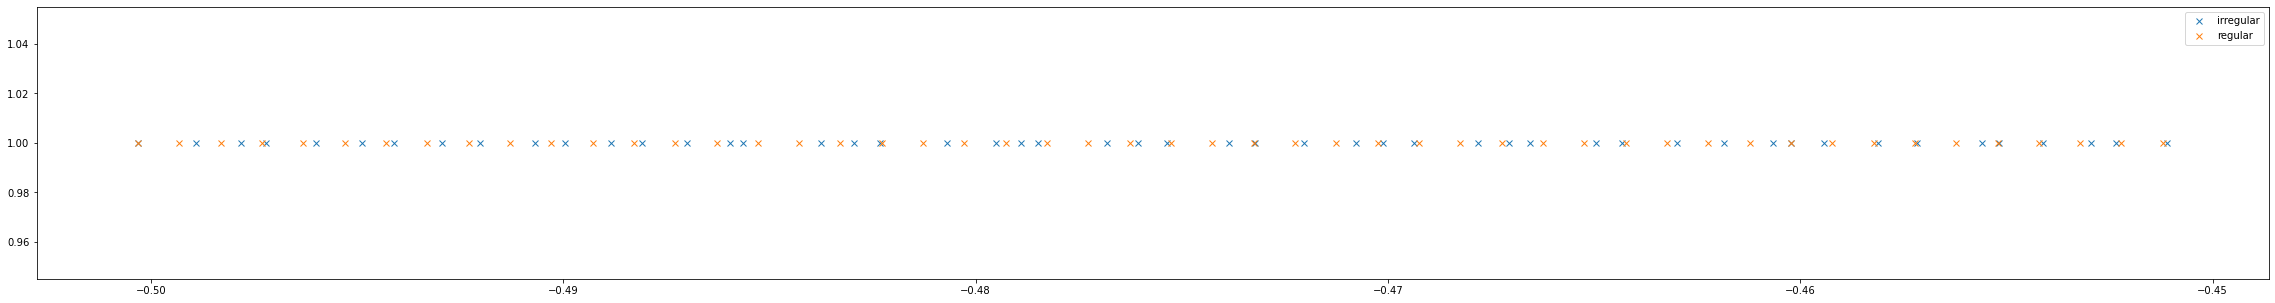

In [9]:
fig = plt.figure(figsize=(40, 5))
plt.plot(time_irregular[:50], np.ones(50), 'x', label='irregular')
plt.plot(time_regular[:50],np.ones(50), 'x', label='regular')
plt.legend()

In [10]:
interpolator = interpolate.interp1d(x=time_irregular, y=white_noise)
white_noise_interpolated = interpolator(time_regular) # Interpolate white noise to regular time intervals
white_noise_interpolated.shape

(1000,)

In [11]:
lc_regular = Lightcurve(time=time_regular, counts=white_noise, err_dist="gauss")
lc_irregular = Lightcurve(time=time_regular, counts=white_noise_interpolated, err_dist="gauss")

d:\repos\stingray\stingray\utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [12]:
lc_regular.dt

0.0010020524536584752

Using 7 DPSS windows for multitaper spectrum estimator
Using 7 DPSS windows for multitaper spectrum estimator


d:\repos\stingray\stingray\utils.py:126: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
d:\repos\stingray\stingray\utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


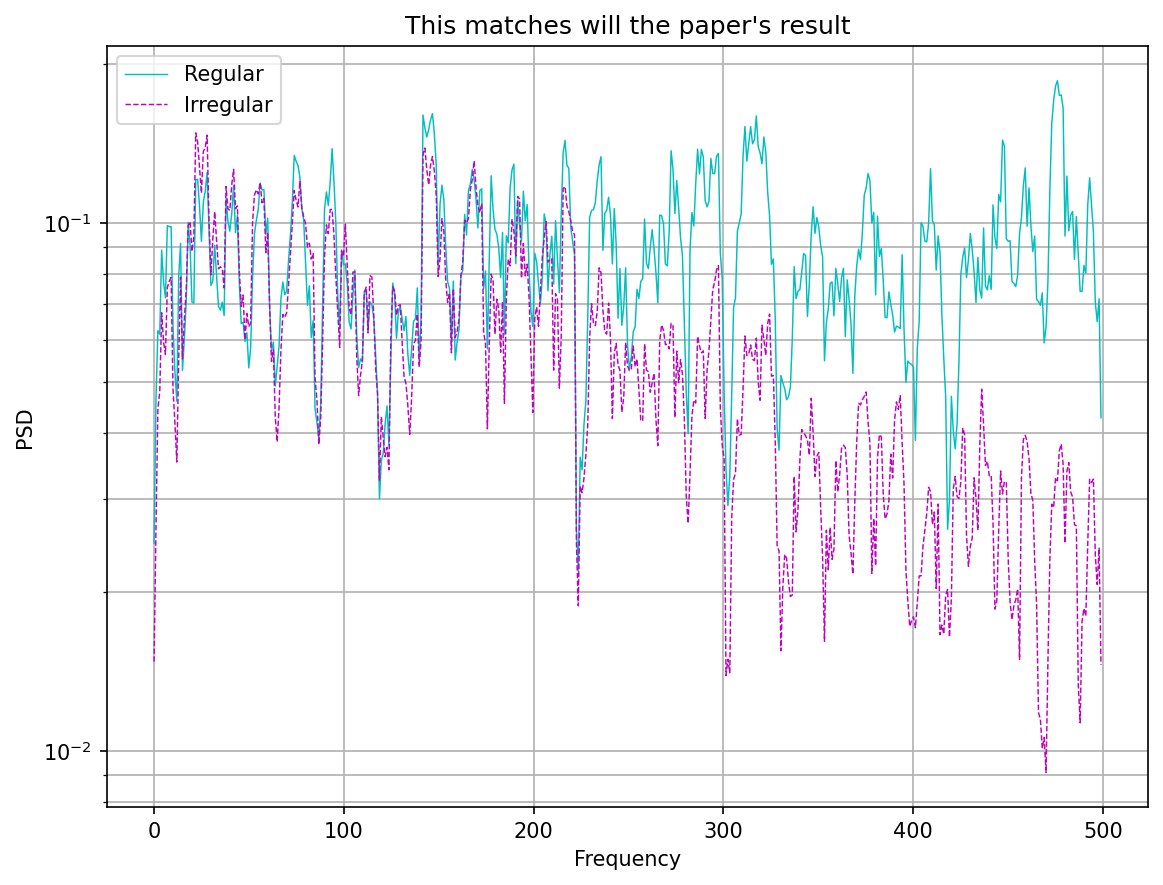

In [13]:
mtp_regular = Multitaper(lc_regular, adaptive=False)
mtp_irregular = Multitaper(lc_irregular, adaptive=False)

plot(freqs=[mtp_regular.freq, mtp_irregular.freq],
    powers=[mtp_regular.multitaper_norm_power, mtp_irregular.multitaper_norm_power],
    labels=["Regular", "Irregular"],
    title="This matches will the paper's result")

In [14]:
dpss_tapers, eigvals = signal.windows.dpss(M=lc_irregular.n, NW=4, Kmax=7,
                                sym=False, return_ratios=True)
dpss_tapers.shape

(7, 1000)

In [15]:
lc_irregular.n

1000

In [16]:
(time_irregular[-1]-time_irregular[0])/time_irregular.shape[0]

0.0010010504012048411

In [17]:
dpss_tapers_interpolated_at_irregular = []

for dpss_taper in dpss_tapers:
    cubic_spline_interp = interpolate.InterpolatedUnivariateSpline(time_regular, dpss_taper, k=3)
    dpss_interpolated = cubic_spline_interp(time_irregular) # interpolating DPSS tapers to IRREGULAR times
    dpss_interpolated /= np.sum(dpss_interpolated**2) # Re normalizing
    dpss_tapers_interpolated_at_irregular.append(dpss_interpolated)
    
dpss_tapers_interpolated_at_irregular = np.array(dpss_tapers_interpolated_at_irregular)

In [18]:
dpss_tapers_interpolated_at_irregular.shape

(7, 1000)

In [19]:
np.mean(dpss_tapers_interpolated_at_irregular - dpss_tapers)

-7.40382440572822e-07

In [20]:
data_multitaper_ls = white_noise - np.mean(white_noise)  # De-mean
data_multitaper_ls = np.tile(data_multitaper_ls, (len(eigvals), 1))
data_multitaper_ls = np.multiply(data_multitaper_ls, dpss_tapers_interpolated_at_irregular)

freq_multitaper_ls = scipy.fft.rfftfreq(lc_irregular.n, d=lc_irregular.dt)

In [21]:
psd_mtls = []
weights = np.sqrt(eigvals)[:, np.newaxis]
scaled_time_irregular = np.interp(time_irregular, (time_irregular.min(), time_irregular.max()), (-0.5, +0.5)) # Scaling time to (-0.5, 0.5) interval
print(min(scaled_time_irregular), max(scaled_time_irregular))
for idx, data, weight in zip(range(len(eigvals)), data_multitaper_ls, weights):
    
    psd = (signal.lombscargle(scaled_time_irregular, white_noise, 2*np.pi*freq_multitaper_ls[1:])) # slicing so as not to include zero
    dft = np.sqrt(2*psd)
    
    if idx % 2 == 0: 
        dft = -dft
    else:
        dft = dft.conj()
        
    dft *= weight
    psd_mtls.append(dft)
    
psd_mtls = np.array(psd_mtls)


# from stingray.Multitaper import psd_from_freq_response
# frs = fft.rfft(data_multitaper_ls, n=lc_regular.n)

# 

# psd_mtls = psd_from_freq_response(frs, weights)

psd_mtls *= psd_mtls.conj()
psd_mtls = psd_mtls.real.sum(axis=-2)  # Sum all rows
psd_mtls *= 2 / (weights * weights.conj()).real.sum(axis=-2)



-0.5 0.5


In [22]:
psd_mtls *= lc_irregular.dt
# psd_mtls /= 5
# psd_mtls /= lc_irregular.n

In [23]:
psd_mtls.shape
# mtp_regular.power.shape

(500,)

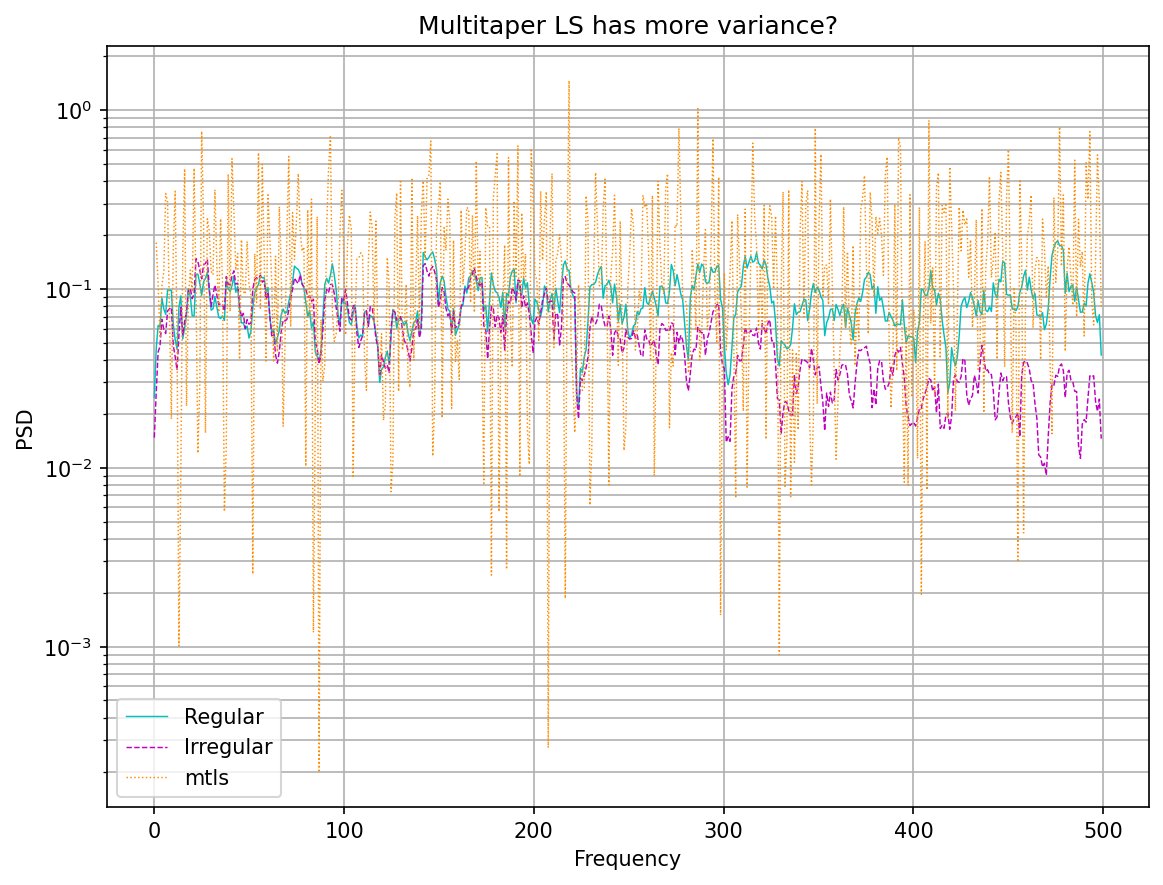

In [24]:
plot(freqs=[mtp_regular.freq, mtp_irregular.freq, freq_multitaper_ls[1:]],
    powers=[mtp_regular.multitaper_norm_power, mtp_irregular.multitaper_norm_power, psd_mtls],
    labels=["Regular", "Irregular", "mtls"],
    title="Multitaper LS has more variance?")